# Overview of Dataset
**This dataset contains 4242 images of flowers.The data collection is based on the data flicr, google images, yandex images.You can use this datastet to recognize plants from the photo.The pictures are divided into five classes: chamomile, tulip, rose, sunflower, dandelion.
For each class there are about 800 photos. Photos are not high resolution, about 320x240 pixels. Photos are not reduced to a single size, they have different proportions!**
![image.png](attachment:image.png)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
#from keras.applications import resnet
import cv2
import tensorflow as tf
import os
import random

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten,Concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.model_selection import train_test_split
import math
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

# Loading the Dataset

In [4]:
labels = ['dandelion', 'daisy','tulip','sunflower','rose']
img_size = 224
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data,dtype=object)

In [5]:
data_dir = "/kaggle/input/flowers-recognition/flowers"
data = get_data(data_dir)

# Data Visualization and Preprocessing

<AxesSubplot:ylabel='count'>

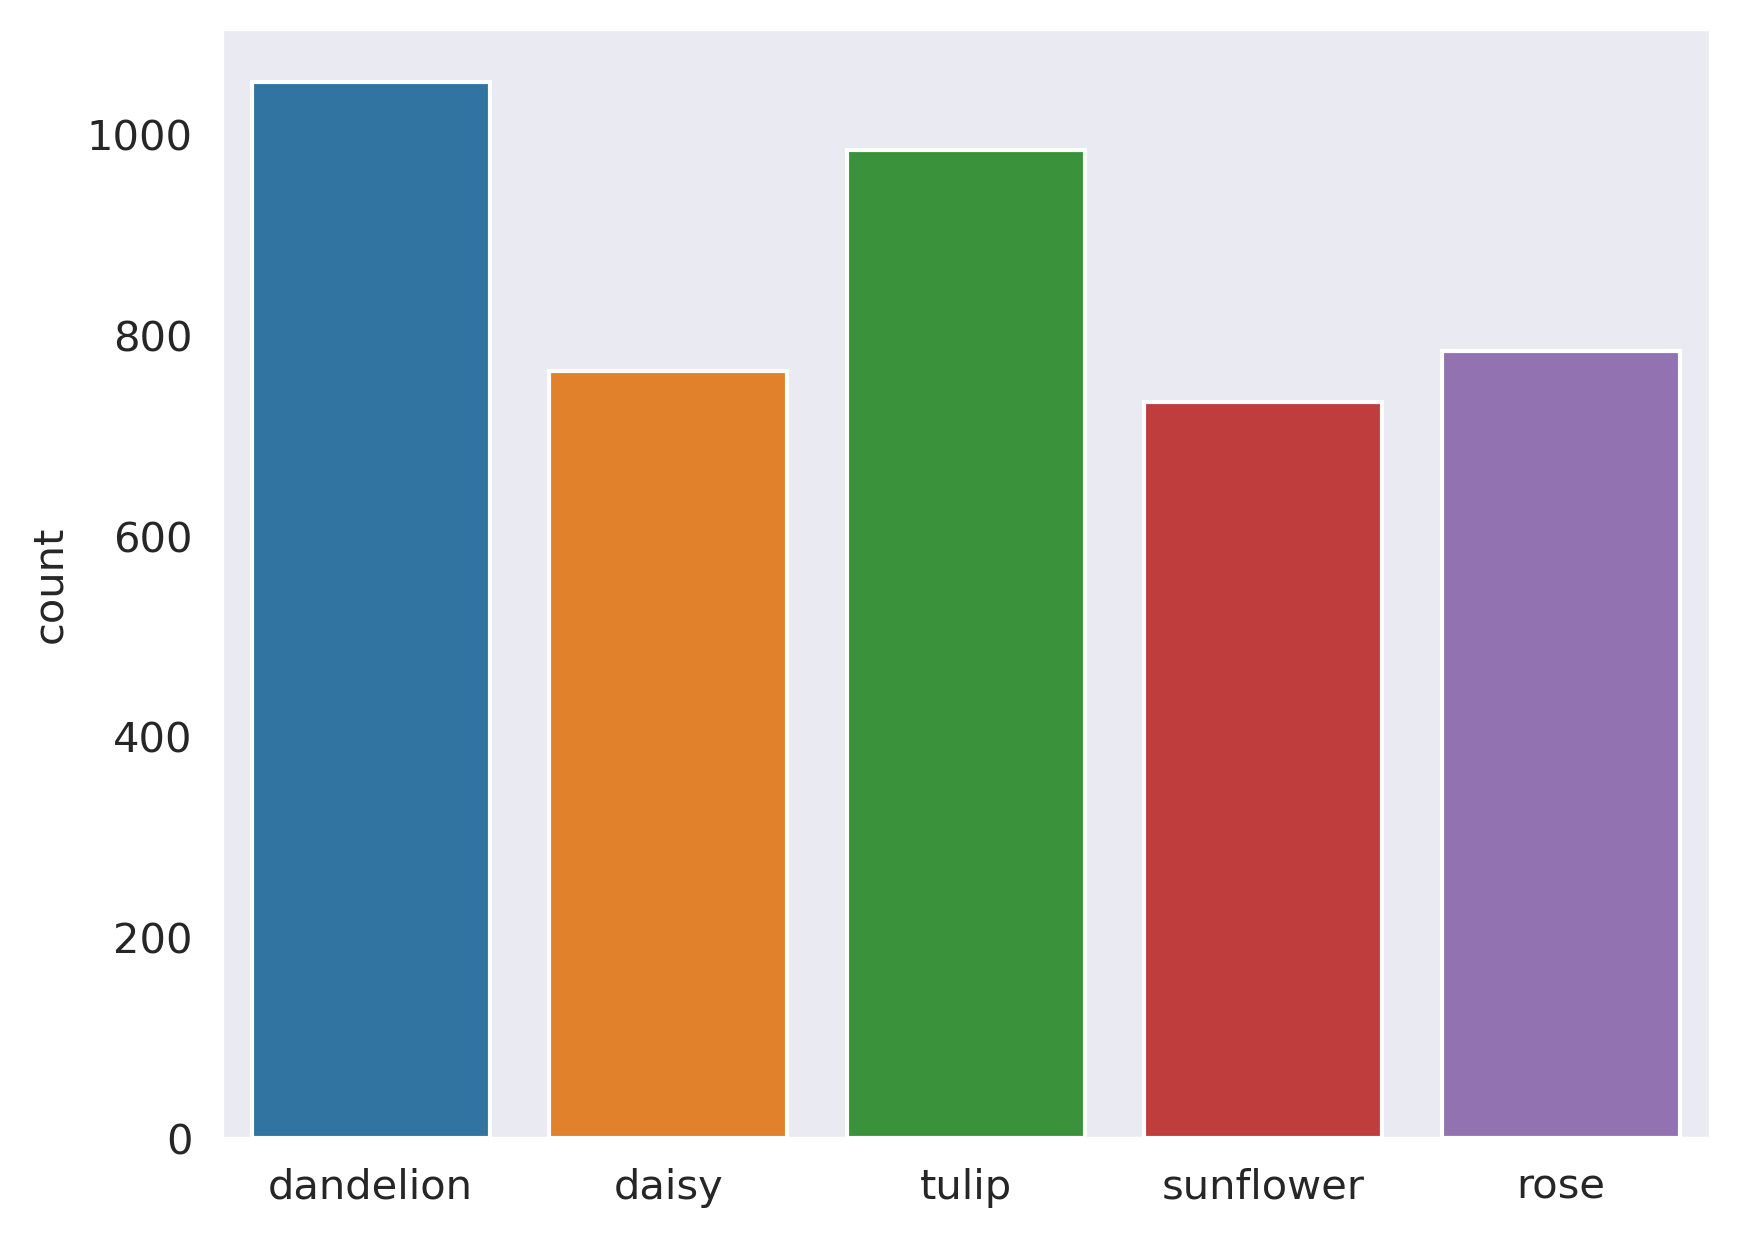

In [6]:
l = []
for i in data:
    l.append(labels[i[1]])
sns.set_style('dark')
sns.countplot(x=l)

**The dataset seems balanced as for each training label , enough training examples exist**

**Randomly Previewing first 10 images**

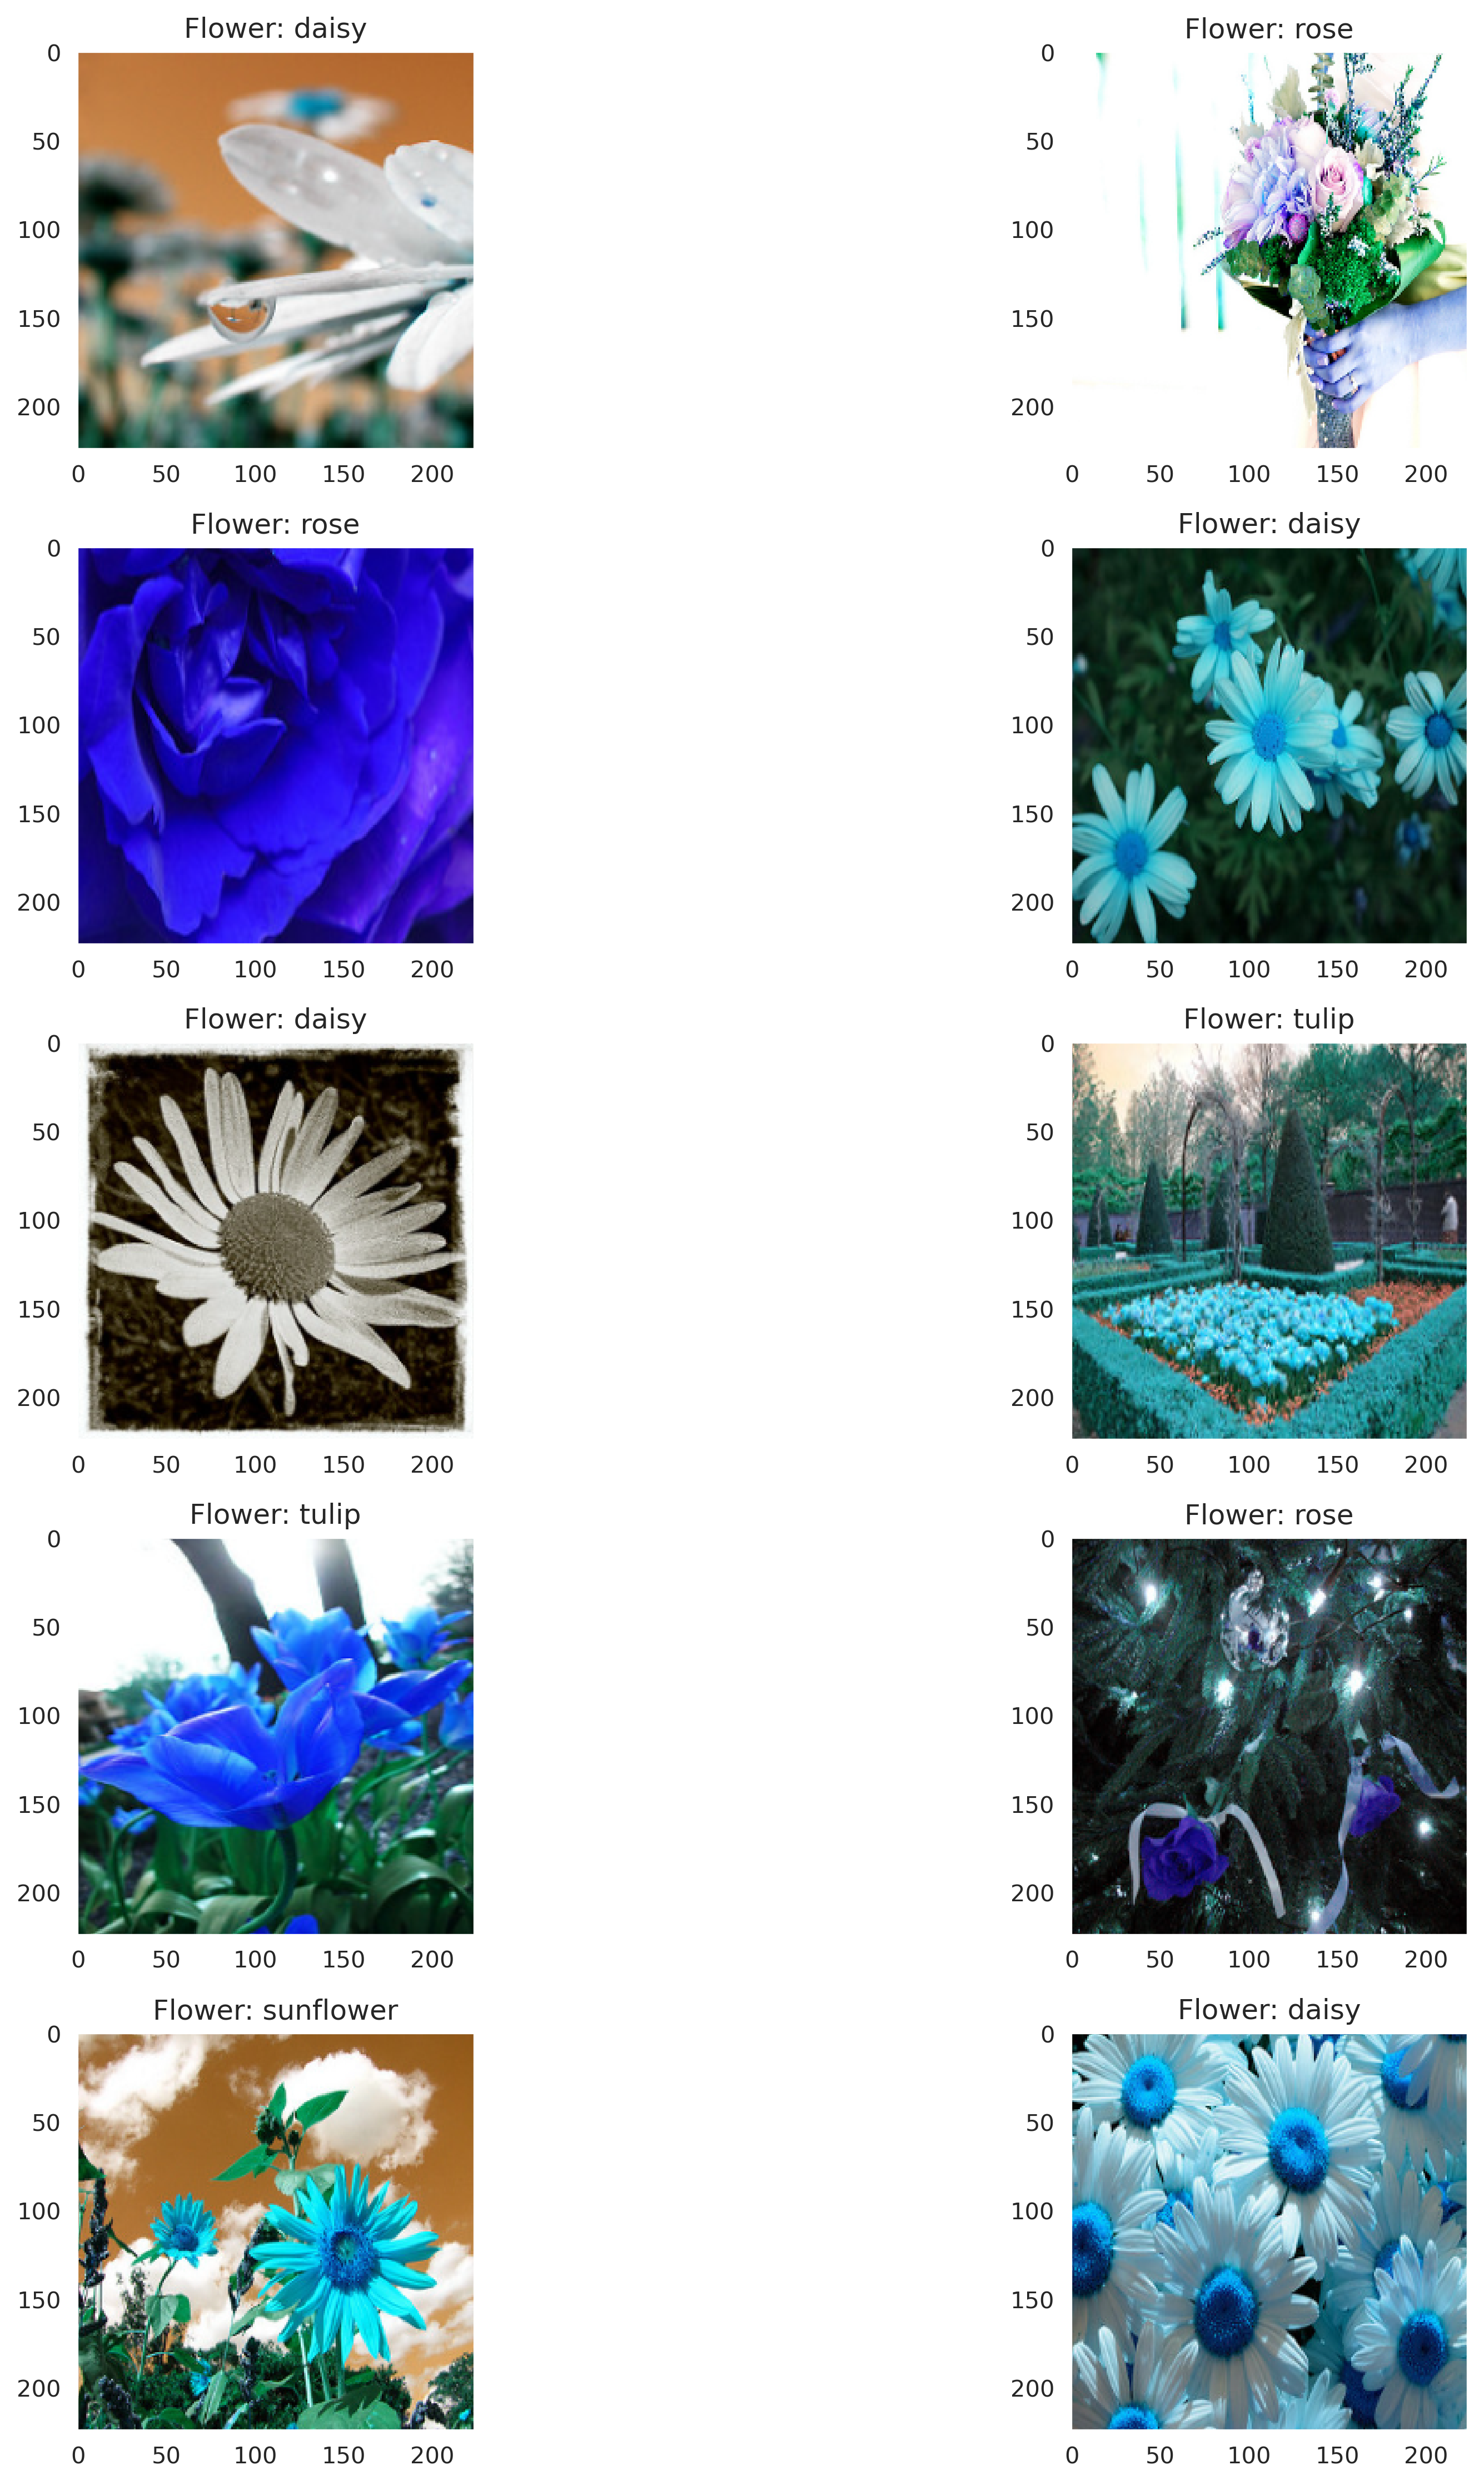

In [7]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=random.randint(0,len(data))
        ax[i,j].imshow(data[l][0])
        ax[i,j].set_title('Flower: '+labels[data[l][1]])
        
plt.tight_layout()

In [8]:
x = []
y = []

for feature, label in data:
    x.append(feature)
    y.append(label)

**We perform a grayscale normalization to reduce the effect of illumination's differences.Moreover the CNN converges faster on [0..1] data than on [0..255].**

In [9]:
# Normalize the data
x = np.array(x) / 255

In [10]:
# Reshaping the data from 1-D to 3-D as required through input by CNN's 
x = x.reshape(-1, img_size, img_size, 3)
y = np.array(y)

In [11]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y = label_binarizer.fit_transform(y)

In [12]:
x_train,x_test,y_train,y_test = train_test_split(x , y , test_size = 0.2 , stratify = y , random_state = 0)

In [13]:
del x,y,data

In [14]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


# Training The Model

In [15]:
def fire_model(x, s_1x1, e_1x1, e_3x3, fire_name):
    # squeeze part
    squeeze_x = Conv2D(kernel_size=(1,1),filters=s_1x1,padding='same',activation='relu',name=fire_name+'_s1')(x)
    # expand part
    expand_x_1 = Conv2D(kernel_size=(1,1),filters=e_1x1,padding='same',activation='relu',name=fire_name+'_e1')(squeeze_x)
    expand_x_3 = Conv2D(kernel_size=(3,3),filters=e_3x3,padding='same',activation='relu',name=fire_name+'_e3')(squeeze_x)
    expand = Concatenate(axis = 3, name=fire_name)([expand_x_1, expand_x_3])
    return expand

In [16]:
def squeezeNet(x):
    conv1 = Conv2D(input_shape = (224,224,3), strides = 2, filters=96, kernel_size=(7,7), padding='same', activation='relu')(x)
    poo1 = MaxPool2D((2,2))(conv1)
    fire2 = fire_model(poo1, 16, 64, 64,'fire2')
    fire3 = fire_model(fire2, 16, 64, 64,'fire3')
    fire4 = fire_model(fire3, 32, 128, 128,'fire4')
    pool2 = MaxPool2D((2,2))(fire4)
    fire5 = fire_model(pool2, 32, 128, 128,'fire5')
    fire6 = fire_model(fire5, 48, 192, 192,'fire6')
    fire7 = fire_model(fire6, 48, 192, 192,'fire7')
    fire8 = fire_model(fire7, 64, 256, 256,'fire8')
    pool3 = MaxPool2D((2,2))(fire8)
    fire9 = fire_model(pool3, 64, 256, 256,'fire9')
    dropout1 = Dropout(0.5)(fire9)
    conv10 = Conv2D(kernel_size=(1,1), filters=5, padding='same', activation='relu')(dropout1)
    gap = GlobalAveragePooling2D()(conv10)
#     score = Dense(10, activation='softmax')
    return gap

In [17]:
input_img = Input(shape = (224,224,3))
model = Model(input_img,squeezeNet(input_img))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 96  14208       ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 tf.compat.v1.nn.max_pool (TFOp  (None, 56, 56, 96)  0           ['conv2d[0][0]']                 
 Lambda)                                                                                      

In [18]:
model.compile(optimizer = "adam" , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

In [19]:
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.004)


In [20]:
history = model.fit(x_train,y_train, batch_size = 64 , epochs = 50 , validation_data = (x_test, y_test),callbacks = [learning_rate_reduction])

Epoch 1/50
54/54 [==============================] - 36s 580ms/step - loss: 1.7428 - accuracy: 0.2383 - val_loss: 1.6012 - val_accuracy: 0.2431 - lr: 0.0010
Epoch 2/50
54/54 [==============================] - 28s 526ms/step - loss: 1.5988 - accuracy: 0.2482 - val_loss: 1.6055 - val_accuracy: 0.2280 - lr: 0.0010
Epoch 3/50
54/54 [==============================] - 28s 523ms/step - loss: 1.6023 - accuracy: 0.2383 - val_loss: 1.6002 - val_accuracy: 0.2280 - lr: 0.0010
Epoch 4/50
54/54 [==============================] - 28s 525ms/step - loss: 1.6005 - accuracy: 0.2337 - val_loss: 1.5993 - val_accuracy: 0.2280 - lr: 0.0010
Epoch 5/50
54/54 [==============================] - 28s 527ms/step - loss: 1.5993 - accuracy: 0.2375 - val_loss: 1.5922 - val_accuracy: 0.2384 - lr: 0.0010
Epoch 6/50
54/54 [==============================] - 28s 527ms/step - loss: 1.5774 - accuracy: 0.2557 - val_loss: 1.5394 - val_accuracy: 0.3160 - lr: 0.0010
Epoch 7/50
54/54 [==============================] - 28s 528ms/st

In [21]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

27/27 [==============================] - 1s 48ms/step - loss: 0.8921 - accuracy: 0.7072
Loss of the model is -  0.8920597434043884
27/27 [==============================] - 1s 49ms/step - loss: 0.8921 - accuracy: 0.7072
Accuracy of the model is -  70.71759104728699 %


# Analysis after Model Training

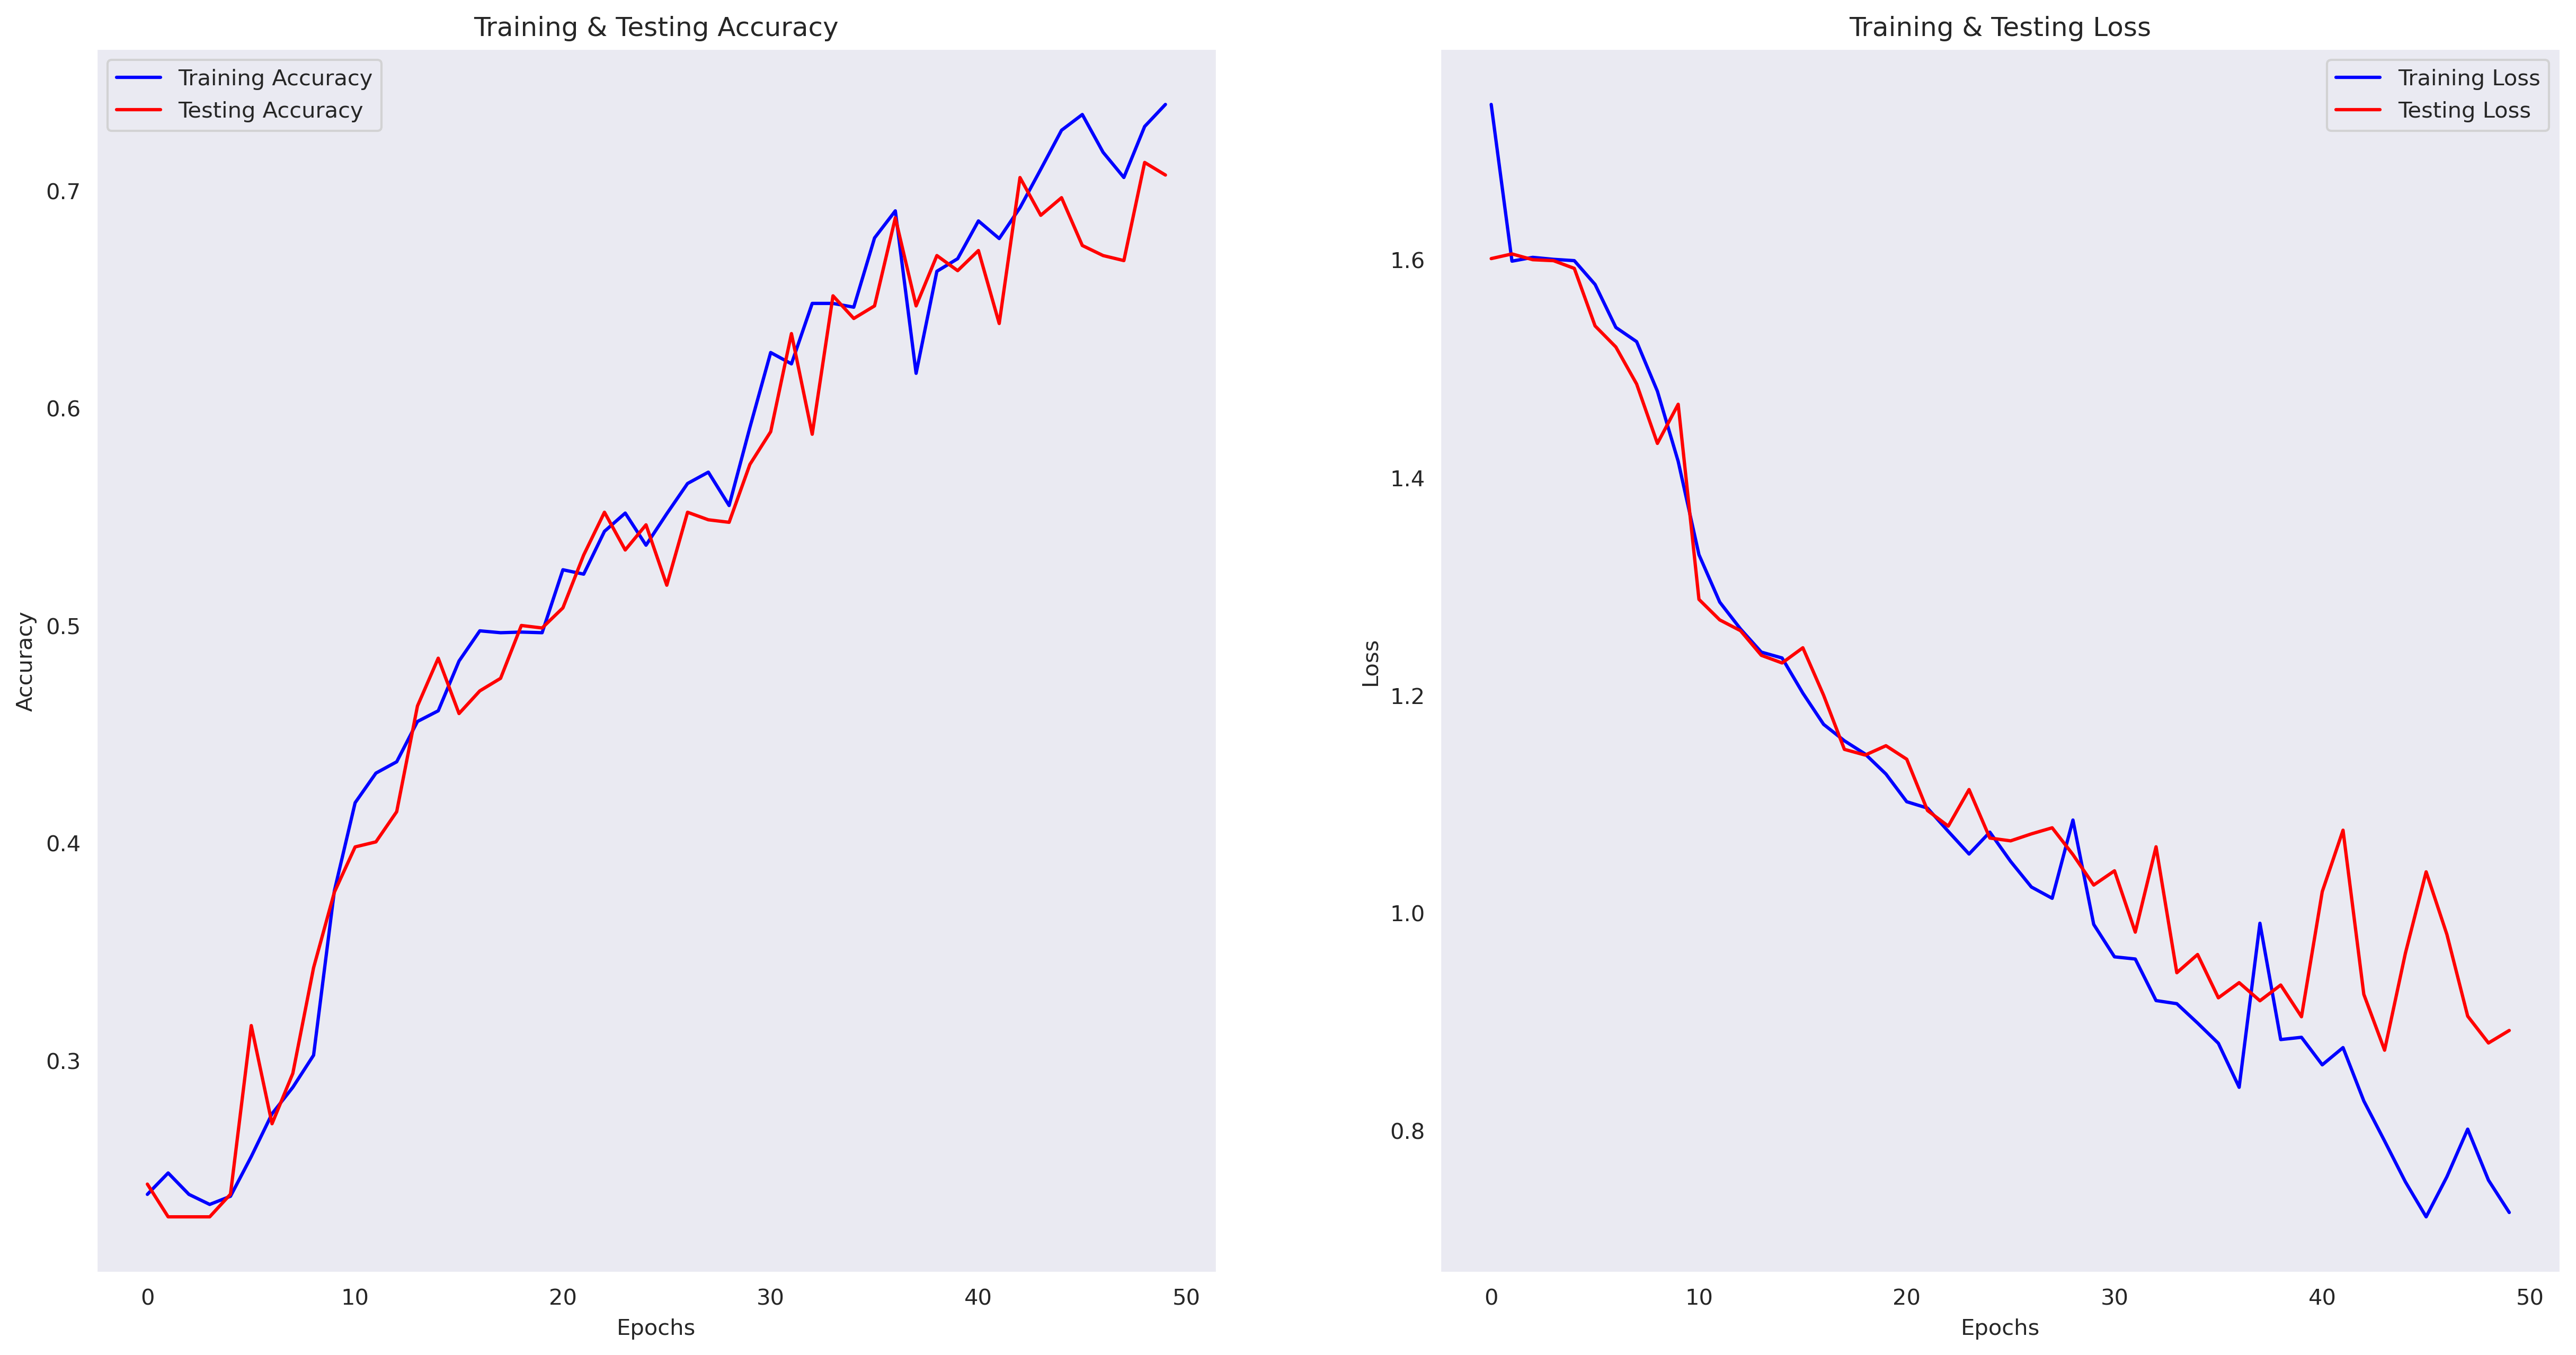

In [22]:
epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'b-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'r-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'b-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()